In [20]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
# read in all words
words = open("../lec1_intro_language_modeling/names.txt").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [22]:
len(words)

32033

In [23]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [24]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one ?
X, Y = [], []
for w in words:
    
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '----->', itos[ix])
        context = context[1:] + [ix] # crop and append . Ruling window
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [25]:
C = torch.randn((27,2)) # matrix of embeddings initialized randomly

In [26]:
F.one_hot(torch.tensor(5),num_classes=27).float() @ C

tensor([ 0.3765, -0.3470])

In [27]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [28]:
emb[:,0,:].shape # all the embeddings of just the first "word" in X
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],dim=1).shape

torch.Size([228146, 6])

In [29]:
b = torch.cat(torch.unbind(emb,dim=1), dim=1)

In [30]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [64]:
g = torch.Generator().manual_seed(2147483647) # to include determinism
C = torch.randn((27,10), generator=g) # matrix of embeddings initialized randomly
W1 = torch.randn((30, 200), generator=g) # 2-dim embedding * 3 context length
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [62]:
sum(n.nelement() for n in parameters)

11897

In [65]:
for p in parameters:
    p.requires_grad = True

In [63]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [66]:
lri = []
lossi =[]
stepi = []

In [70]:

for i in range(50000):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30)  @ W1 + b1) # PyTorch will infer the correct missing dimension
    logits = h @ W2 + b2
    # counts = logits.exp()   # The next 3 lines are called Cross-entropy
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track state
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    
print(loss.item())


2.4188766479492188


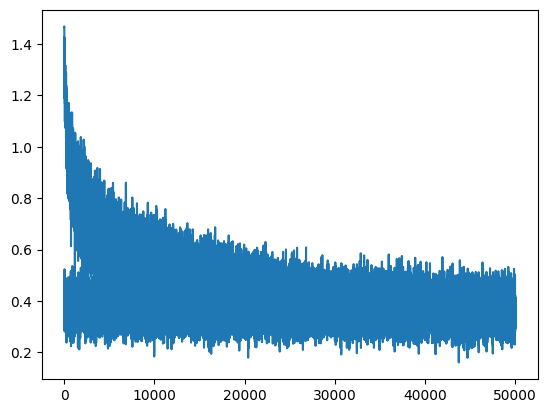

In [71]:
plt.plot(stepi,lossi)

In [72]:
emb = C[Xte]
h = torch.tanh(emb.view(-1,30)  @ W1 + b1) # PyTorch will infer the correct missing dimension
logits = h @ W2 + b2
# counts = logits.exp()   # The next 3 lines are called Cross-entropy
# prob = counts / counts.sum(1, keepdim=True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.3292, grad_fn=<NllLossBackward0>)

In [38]:
# training split (used to train parameters), dev/validation split (used to train hyperparameters), test split
# 80%, 10%, 10%
# build the dataset

def build_dataset(words):
        
    block_size = 3 # context length: how many characters do we take to predict the next one ?
    X, Y = [], []
    for w in words:
        
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '----->', itos[ix])
            context = context[1:] + [ix] # crop and append . Ruling window
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


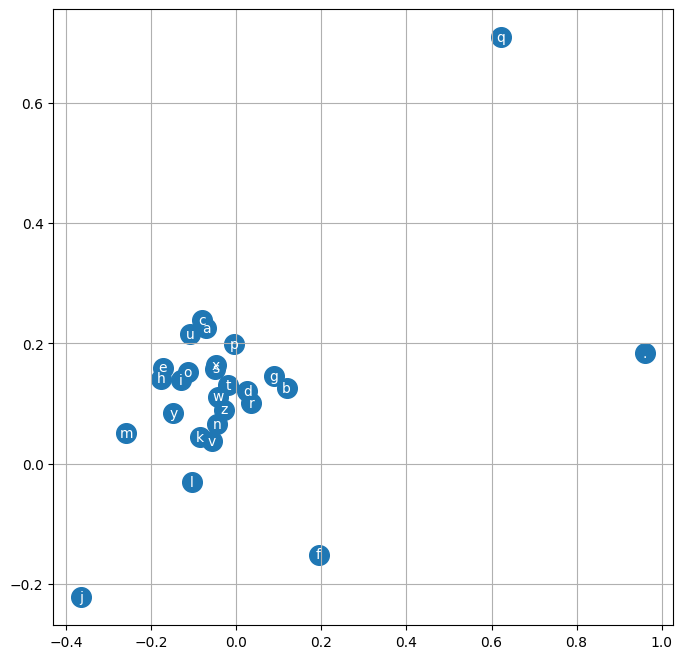

In [73]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')